# E-field calculation and the E-field-spin coupling effect

In [1]:
#importing crucial packages
import numpy as np
import random as rnd
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
#helpful functions - don't worry about them

#This whole part below is used to download 
#a quantum seed from Australia for a quantum number generator.
from urllib.request import urlopen

def getRandom():
    """
    this function communicates with a website of an Australian group that continuously uploads random numbers
    from some kind of quantum based experiment to obtain a truly random seed for python's pseudo random generator
    """
    url = 'http://150.203.48.55/RawHex.php'
    page = urlopen(url, timeout=5)
    data = page.read()
    a = str(data)
    hexy = a.split('<td>\\n')[1].split('</td>')[0]
    num = int(hexy,16)
    return num

#just a function showing a progress bar in the console
import time, sys

def percentDone(x):
    """ 
    x is a float from 0 to 1 representing the progress of a given task 
    this function prints and updates the printout with the percentage of a given task done: 
    """
    n = int(x*20)
    percent = int(x*100)
    hashes = "#"*n+" "*(20-n)
    bar = "|"+hashes+"|"+str(percent)+"% done "
    print("\r"+bar,end='')

In [6]:
def randomPoint(tube,wire,halfDistance):
    """
    generates a random point from inside the sample tube
    """
    generated = False
    
    while not generated:
        x = rnd.random()*(2*tube)-tube
        y = rnd.random()*(2*tube)-tube
        
        # check if outside wires
        
        firstWire = (wire < np.sqrt((x-halfDistance)**2+y**2))
        secondWire = (wire < np.sqrt((x+halfDistance)**2+y**2))
        
        #check if inside the tube
        insideTube  = (tube > np.sqrt(x**2+y**2))
        
        if firstWire*secondWire*insideTube:
            generated = True
    
    return(x,y)

If the radius of the wire is $a$ and the distance between the wires is $d$, linear charge density is $\lambda$, then E-field due to both wires is given by
$$\boldsymbol{E}(x,y) = \frac{\lambda}{2 \pi \varepsilon_0} \left(\frac{d+x}{(x+d)^2+y^2)}+\frac{d-x}{(x-d)^2+y^2)}, \frac{y}{(x+d)^2+y^2)}+\frac{-y}{(x-d)^2+y^2)} \right)$$
Integrating from the edge of one wire to the edge of another wire gives the potential difference between the two wires:
$$V = \frac{\lambda}{\pi \varepsilon_0} \ln \left( \frac{2d+a}{a} \right)$$
Knowing voltage, we can write $\boldsymbol{E}$ as
$$\boldsymbol{E}(x,y) =  \frac{V}{2 \ln \left( \frac{2d+a}{a} \right)} \left(\frac{d+x}{(x+d)^2+y^2)}+\frac{d-x}{(x-d)^2+y^2)}, \frac{y}{(x+d)^2+y^2)}+\frac{-y}{(x-d)^2+y^2)} \right)$$

Because the calculation of the E-field values at random points takes time, I am calculating it only once.

In [7]:
def getE(x,y,halfDistance,maxVoltage):
    """
    calculates the value of both components of E-field for a given point
    """
    d = halfDistance
    constant = maxVoltage/(2*np.log((2*d+wire)/wire))
    
    E_x1 = constant*(x+d)/((x+d)**2+y**2)
    E_x2 = constant*(d-x)/((x-d)**2+y**2)
    E_y1 = constant*y/((x+d)**2+y**2)
    E_y2 = -constant*y/((x-d)**2+y**2)
    
    E_x = E_x1+E_x2
    E_y = E_y1+E_y2
    
    return (E_x,E_y)

We assume a very simple model, where 

$$\Delta \boldsymbol{g} = a \boldsymbol{E}$$

where $a$ is some coupling strength. In other words, a change in $g_x$ is only due to $E_x$ etc. 
Because in the Hamiltonian the g-tensor multiplies the magnetic field, which in this picture is in the $x$ direction, we actually only ever need $E_x$. 

As stated in the variable definitions above, I don't know what $a$ is, so I don't bother adding in all the constants that should be there. That means I will use a constant $\gamma$, which contains the magnetic field. From the dot product between the magnetic field and the change in the tensor we get $\gamma E_x \cos(\theta)$, where $\theta$ is the angle between the $\boldsymbol{B_0}$ and $\boldsymbol{E}$. The additional phase factor is:

$$e^{i \gamma E_x \cos(\theta) t}$$

Where $t$ is time. Assuming the distribution of active molecules is isotropic, we need to integrate that over a surface of a sphere:

$$\int_0^{\pi} \sin (\theta) e^{i \gamma E_x \cos(\theta) t} d \theta = 2 \frac{\sin (\gamma E_x t)}{\gamma E_x t}$$

Then, we need to average over all the sample volume with this phase factor. 

In [40]:
def totalPhaseFactor(ExValues,EScoupling,time):
    """
    calculates the averaged phase factor across all the E-field values for given EScoupling
    """
    N=len(ExValues)
    
    phaseFactorValues = np.zeros(N)

    for i in range(N):
        phase = EScoupling*time*ExValues[i]
        phaseFactorValues[i]= np.sin(phase)/phase
    
    total = sum(phaseFactorValues)/N
    return total

In [41]:
def echoESweep(ExValues,EScoupling,k,tottime):
    """
    k is the number of steps taken. must be even
    tottime is total time
    EScoupling is the coupling
    ExValues are values of E_x component of the electric field across the ensemble, precalculated
    """
    times = tottime*np.linspace(0,1,int(k/2))/k
    phases = np.concatenate((times,times[::-1]))
    
    factors = np.zeros(k)
    for i in range(k):
        factors[i] = totalPhaseFactor(ExValues, EScoupling, phases[i])
        percentDone((i+1)/k)
    print("\n")
    return factors

Let's actually begin

In [4]:
#set up random number generator for Monte Carlo 
num = getRandom()
rnd.seed(num)

# CHANGE VARIABLES HERE

In [47]:
#SPECIFY ALL THE IMPORTANT VARIABLES AND CONSTANTS

halfDistance = 0.01 #half of the distance between the wires in metres
wire = 0.0005 #radius of the wire in metres
tube = 0.011 #radius of the sample tube in metres

maxVoltage = 150 #in volts

EScoupling = 200 #since we don't know what it is for now it just enters as phase = EScoupling*Efield, without all the
                #Bohr magneton and magnetic field stuff. can be changed later

N = 10**6 #number of random points to average over
k = 100 #number of steps in the E-field experiment
tottime = 1.5e-6 #total length of the pulse in seconds

In [21]:
#because of time constraints we are first going to precalculate E-field values

ExValues = np.zeros(N)

for i in range(N):
    (x,y) = randomPoint(tube,wire,halfDistance)
    E_x, E_y = getE(x,y,halfDistance,maxVoltage)
    ExValues[i]=E_x
    
    #percentDone((i+1)/N)
    
ExValues.sort()

An average E-field in the sample is 3344.72138926 V/m.
Compare with a value for a flat capacitor of the same distance between: 7500.0 V/m.


<IPython.core.display.Javascript object>


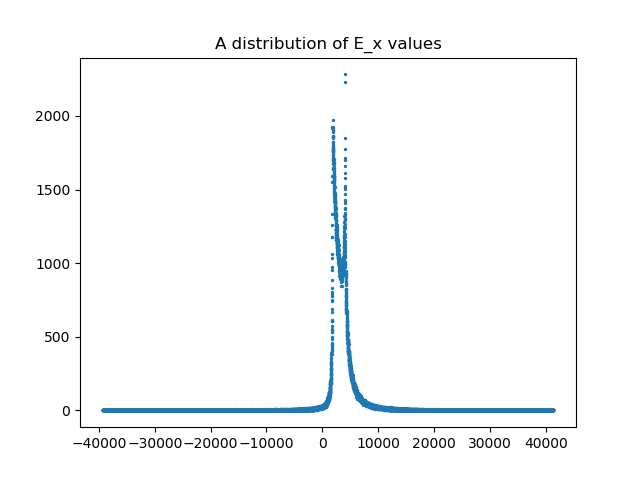

Text(0.5,1,'A distribution of E_x values')

In [31]:
Exhist, Exbin_edges = np.histogram(ExValues,bins=int(N/50))
print("An average E-field in the sample is "+str(sum(ExValues)/N)+" V/m.")
E_flat = maxVoltage/(2*halfDistance)
print("Compare with a value for a flat capacitor of the same distance between: "+str(E_flat)+ " V/m.")
print("The graph has a long tail due to the points very close to the wires.")

plt.scatter(Exbin_edges[:-1],Exhist,s=2)
plt.title("A distribution of E_x values")

In [46]:
totalPhaseFactor(ExValues,200,1e-6)

0.89574048802078921

In [ ]:
factors = echoESweep(ExValues,EScoupling,100,tottime)

plt.figure()
plt.plot(factors)

C:\Users\cazol\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


|#                   |6% done 

<IPython.core.display.Javascript object>


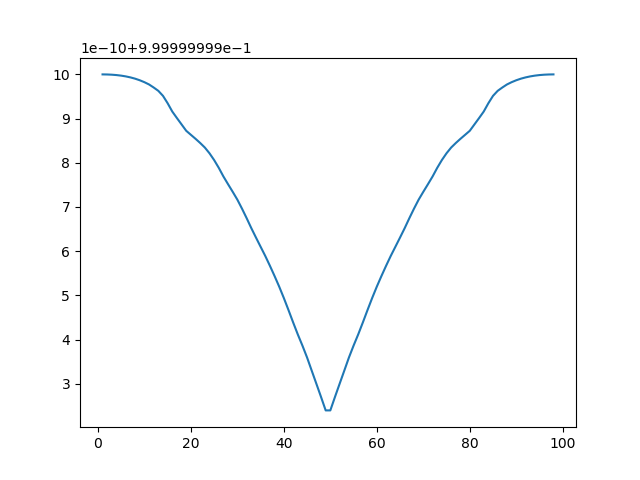

In [36]:
plt.figure()
plt.plot(factors)